# Think Bayes

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'



In [3]:
# import everything from SymPy.
from sympy import symbols, exp, factorial, init_printing

# Set up Jupyter notebook to display math.
init_printing()

In [4]:
λ, t, k = symbols('λ, t, k')

In [5]:
pmf = (λ*t)**k * exp(-λ*t) / factorial(k)

In [6]:
k1, k2, k3, k4 = symbols('k1, k2, k3, k4')

In [7]:
pmf_1 = pmf.subs(dict(k=k1))

In [8]:
pmf_2 = pmf.subs(dict(k=k2))

In [9]:
pmf_3 = pmf.subs(dict(k=k3))

In [10]:
pmf_4 = pmf.subs(dict(k=k4))

In [11]:
ratio = (pmf_1 * pmf_2) / (pmf_3 * pmf_4)
ratio.simplify()

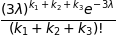

In [14]:
pmf_1 = pmf.subs(dict(k=k1, t=1))
pmf_2 = pmf.subs(dict(k=k2, t=1))
pmf_3 = pmf.subs(dict(k=k3, t=1))
pmf_sum = pmf.subs(dict(k=k1+k2+k3, t=3))

In [15]:
ratio = (pmf_1 * pmf_2) / pmf_sum
ratio.simplify()

In [16]:
import numpy as np
from scipy.stats import poisson

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Joint

import thinkbayes2
import thinkplot

In [18]:
n = 60
t1 = 30
t2 = n-t1
lam1 = 4
lam2 = 2

In [19]:
before = poisson(lam1).rvs(t1)

array([3, 4, 6, 1, 4, 3, 3, 2, 4, 3, 3, 2, 2, 2, 3, 5, 7, 7, 4, 2, 4, 4,
       5, 3, 5, 3, 2, 4, 7, 2])

In [20]:
after = poisson(lam2).rvs(t2)

array([1, 1, 4, 4, 2, 0, 1, 0, 5, 1, 4, 2, 2, 2, 1, 1, 2, 1, 0, 3, 2, 3,
       4, 1, 7, 4, 0, 1, 1, 3])

In [21]:
data = np.concatenate([before, after])

array([3, 4, 6, 1, 4, 3, 3, 2, 4, 3, 3, 2, 2, 2, 3, 5, 7, 7, 4, 2, 4, 4,
       5, 3, 5, 3, 2, 4, 7, 2, 1, 1, 4, 4, 2, 0, 1, 0, 5, 1, 4, 2, 2, 2,
       1, 1, 2, 1, 0, 3, 2, 3, 4, 1, 7, 4, 0, 1, 1, 3])

In [22]:
poisson.pmf(before, 4)

array([0.19536681, 0.19536681, 0.10419563, 0.07326256, 0.19536681,
       0.19536681, 0.19536681, 0.14652511, 0.19536681, 0.19536681,
       0.19536681, 0.14652511, 0.14652511, 0.14652511, 0.19536681,
       0.15629345, 0.05954036, 0.05954036, 0.19536681, 0.14652511,
       0.19536681, 0.19536681, 0.15629345, 0.19536681, 0.15629345,
       0.19536681, 0.14652511, 0.19536681, 0.05954036, 0.14652511])

In [23]:
poisson.pmf(after, 2)

array([0.27067057, 0.27067057, 0.09022352, 0.09022352, 0.27067057,
       0.13533528, 0.27067057, 0.13533528, 0.03608941, 0.27067057,
       0.09022352, 0.27067057, 0.27067057, 0.27067057, 0.27067057,
       0.27067057, 0.27067057, 0.27067057, 0.13533528, 0.18044704,
       0.27067057, 0.18044704, 0.09022352, 0.27067057, 0.00343709,
       0.09022352, 0.13533528, 0.27067057, 0.27067057, 0.18044704])

In [24]:
class Change(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: array of counts
        hypo: t, lam1, lam2
        """
        t1, lam1, lam2 = hypo
        before = data[:t1]
        after = data[t1:]
        like1 = np.prod(poisson.pmf(before, lam1))
        like2 = np.prod(poisson.pmf(after, lam2))
        return like1 * like2

In [25]:
ts = range(1, len(data))

range(1, 60)

In [26]:
lams = np.linspace(0, 10, 51)

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [27]:
from itertools import product
hypos = product(ts, lams, lams)

In [28]:
suite = Change(hypos);

In [29]:
%time suite.Update(data)

CPU times: user 19.2 s, sys: 4 ms, total: 19.2 s
Wall time: 19.2 s


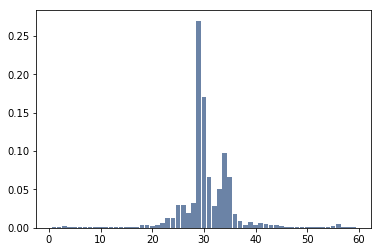

In [30]:
pmf_t = suite.Marginal(0)
thinkplot.Hist(pmf_t)

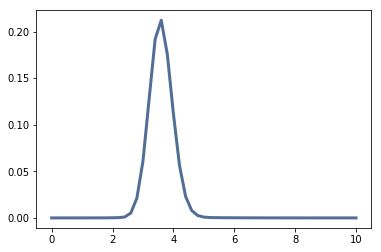

In [31]:
pmf_lam1 = suite.Marginal(1)
thinkplot.Pdf(pmf_lam1)

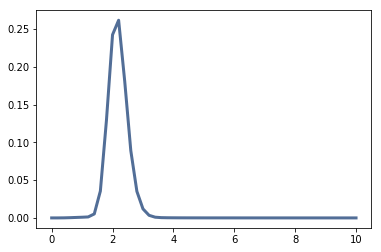

In [32]:
pmf_lam2 = suite.Marginal(2)
thinkplot.Pdf(pmf_lam2)

In [34]:
import pymc3 as pm

RuntimeError: To use MKL 2018 with Theano you MUST set "MKL_THREADING_LAYER=GNU" in your environement.

In [ ]:
model = 